In [1]:
import os 
import cv2
import copy
import numpy as np
import xml.etree.ElementTree as ET
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

In [2]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [3]:
train_image_folder = "C:\\Users\\F. Oseni\\testpictures\\dataset\\VOC2012\\JPEGImages\\"
train_annot_folder = "C:\\Users\\F. Oseni\\testpictures\\dataset\\VOC2012\\Annotations\\"

In [7]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


In [8]:
train_image[:2]

[{'object': [{'name': 'person',
    'xmin': 174,
    'ymin': 101,
    'xmax': 349,
    'ymax': 351}],
  'filename': 'C:\\Users\\F. Oseni\\testpictures\\dataset\\VOC2012\\JPEGImages\\2007_000027.jpg',
  'width': 486,
  'height': 500},
 {'object': [{'name': 'aeroplane',
    'xmin': 104,
    'ymin': 78,
    'xmax': 375,
    'ymax': 183},
   {'name': 'aeroplane', 'xmin': 133, 'ymin': 88, 'xmax': 197, 'ymax': 123},
   {'name': 'person', 'xmin': 195, 'ymin': 180, 'xmax': 213, 'ymax': 229},
   {'name': 'person', 'xmin': 26, 'ymin': 189, 'xmax': 44, 'ymax': 238}],
  'filename': 'C:\\Users\\F. Oseni\\testpictures\\dataset\\VOC2012\\JPEGImages\\2007_000032.jpg',
  'width': 500,
  'height': 281}]

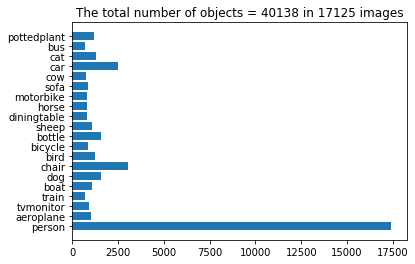

In [9]:
y_pos = np.arange(len(seen_train_labels))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.barh(y_pos,list(seen_train_labels.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(seen_train_labels.keys()))
ax.set_title("The total number of objects = {} in {} images".format(
    np.sum(list(seen_train_labels.values())),len(train_image)
))
plt.show()

In [10]:
wh = []
for anno in train_image:
    aw = float(anno['width'])  # width of the original image
    ah = float(anno['height']) # height of the original image
    for obj in anno["object"]:
        w = (obj["xmax"] - obj["xmin"])/aw # make the width range between [0,GRID_W)
        h = (obj["ymax"] - obj["ymin"])/ah # make the width range between [0,GRID_H)
        temp = [w,h]
        wh.append(temp)
wh = np.array(wh)
print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (40138, 2)


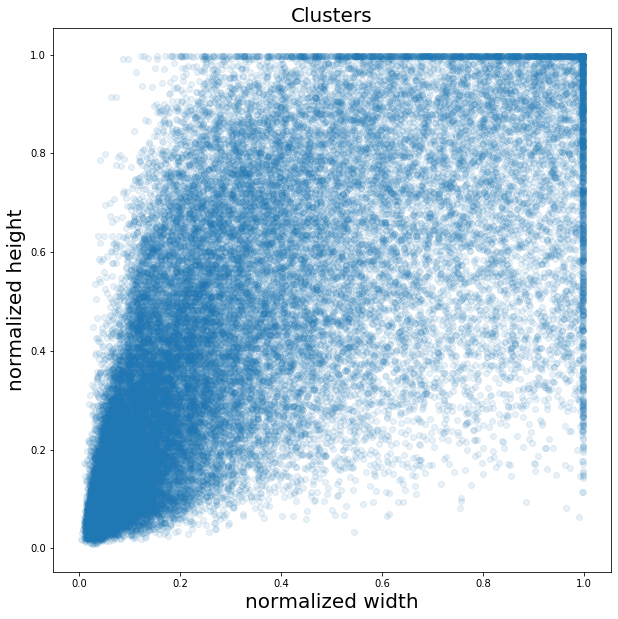

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(wh[:,0],wh[:,1],alpha=0.1)
plt.title("Clusters",fontsize=20)
plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)
plt.show()

In [12]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [13]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

In [14]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4646
 3 clusters: mean IoU = 0.5391
 4 clusters: mean IoU = 0.5801
 5 clusters: mean IoU = 0.6016
 6 clusters: mean IoU = 0.6253
 7 clusters: mean IoU = 0.6434
 8 clusters: mean IoU = 0.6595
 9 clusters: mean IoU = 0.6712
10 clusters: mean IoU = 0.6840


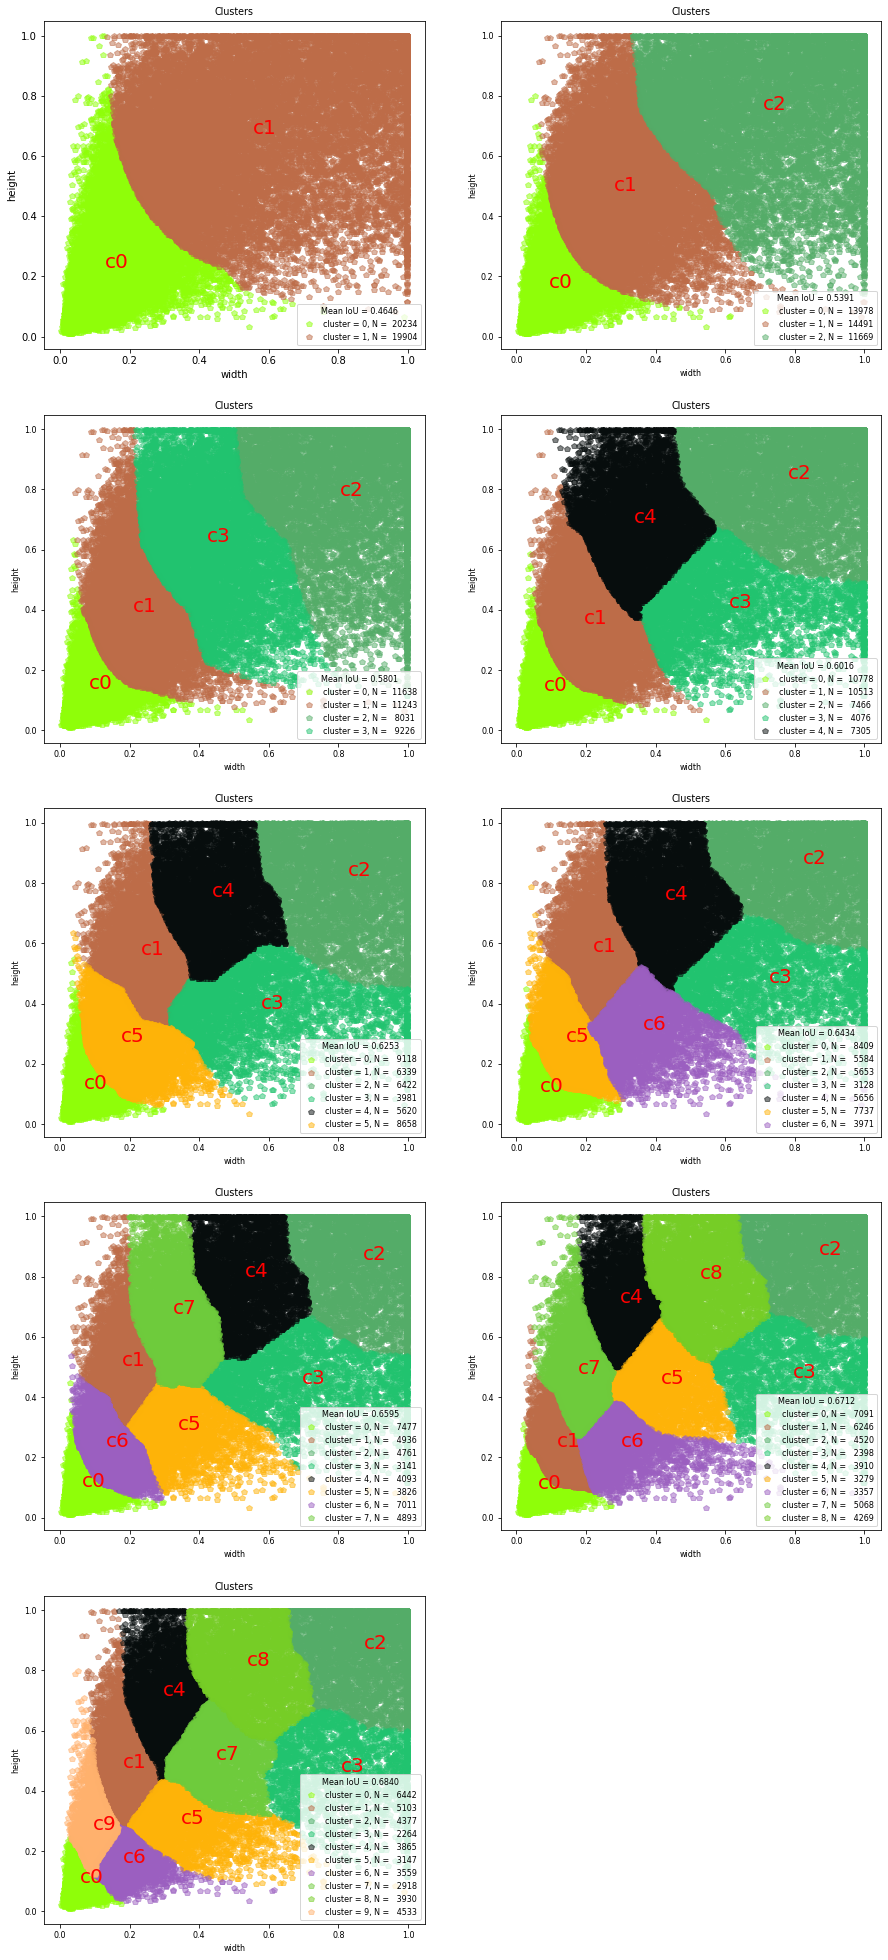

In [15]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh)
    count += 1
plt.show()

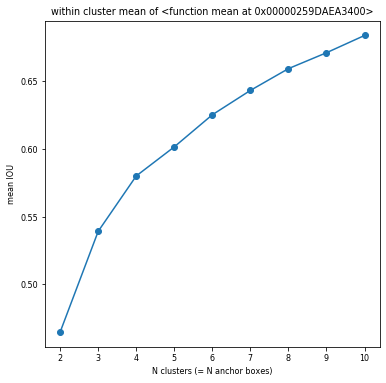

In [16]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

In [17]:
Nanchor_box = 4
results[Nanchor_box]["clusters"]

array([[0.08285376, 0.13705531],
       [0.20850361, 0.39420716],
       [0.80552421, 0.77665105],
       [0.42194719, 0.62385487]])

In [20]:
import copy
class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W, norm=None):
        '''
        IMAGE_H : the height of the rescaled image, e.g., 416
        IMAGE_W : the width of the rescaled image, e.g., 416
        '''
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True):     
        # resize the image to standard size
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.
        
        -- Input -- 
        
        train_instance : dictionary containing filename, height, width and object
        
        {'filename': 'ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2008_000054.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird', 
                     'xmax': 198, 
                     'xmin': 112, 
                     'ymax': 209, 
                     'ymin': 146}]
        }
        
        '''
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        h, w, c = image.shape
        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        if "object" in train_instance.keys():
            
            all_objs = copy.deepcopy(train_instance['object'])     

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs
inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print(image.shape)

(416, 416, 3)


******************************
Input
  object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
  filename: C:\Users\F. Oseni\testpictures\dataset\VOC2012\JPEGImages\2007_000027.jpg
  width: 486
  height: 500
******************************
Output
[{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}]
******************************
End


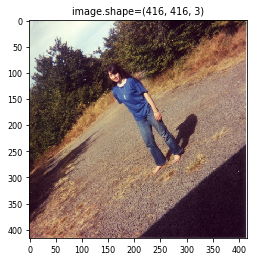

In [19]:
def normalize(image):
    return image / 255.

print("*"*30)
print("Input")
timage = train_image[0]
for key, v in timage.items():
    print("  {}: {}".format(key,v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print("{}".format(all_objs))

print("*"*30)
print("End")
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

In [21]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of even number length e.g.
        
        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box 
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        '''
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
        # each Anchor box is specialized to have a certain shape.
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        ##  For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        ## the code below are used during inference
        # probability
        self.confidence      = confidence
        # class probaiblities [c1, c2, .. cNclass]
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])


In [22]:
_ANCHORS01 = np.array([0.08285376, 0.13705531, 0.20850361, 0.39420716, 0.80552421, 0.77665105, 0.42194719, 0.62385487])
print(".."*40)
print("The three example anchor boxes:")
count = 0
for i in range(0,len(_ANCHORS01),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS01[i],_ANCHORS01[i+1]))
    count += 1
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS01)
for w in range(1,9,2):
    w /= 10.
    for h in range(1,9,2): 
        h /= 10.
        best_anchor,max_iou = babf.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(w,h,best_anchor,max_iou))

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3

In [23]:
 def rescale_centerxy(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    center_x = .5*(obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5*(obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_cebterwh(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''    
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w,center_h)

In [24]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}
center_x, center_y = rescale_centerxy(obj,config)
center_w, center_h = rescale_cebterwh(obj,config)

print("cebter_x abd cebter_w should range between 0 and {}".format(config["GRID_W"]))
print("cebter_y abd cebter_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

cebter_x abd cebter_w should range between 0 and 13
cebter_y abd cebter_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


In [25]:
from keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        '''
        config : dictionary containing necessary hyper parameters for traning. e.g., 
            {
            'IMAGE_H'         : 288, 
            'IMAGE_W'         : 288,
            'GRID_H'          : 9,  
            'GRID_W'          : 9,
            'LABELS'          : ['face'],
            'ANCHORS'         : array([ 0.07588889, 0.26183333, 0.34778819, 0.40873611, 0.43008641, 0.5826978, 0.20055123, 0.37060906]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }
        
        '''
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)#4
        self.config["CLASS"] = len(self.config['LABELS'])#face
        self.images = images #image is a dictionary containing the annoation infomation of an image.
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_cebterwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

Using TensorFlow backend.


In [26]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS 

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [27]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
generator_config = {
    'IMAGE_H'         : IMAGE_H, #288
    'IMAGE_W'         : IMAGE_W, #288
    'GRID_H'          : GRID_H,  #9
    'GRID_W'          : GRID_W,  #9
    'LABELS'          : LABELS,  #face only for now
    'ANCHORS'         : ANCHORS, #np array of the anchors w and h 
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

#train_image is  dictionary of the image with their labels and their corrrsponding pounding box
[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)

In [28]:
iframe= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))
check_object_in_grid_anchor_pair(iframe)

igrid_h=06,igrid_w=06,iAnchor=02, person


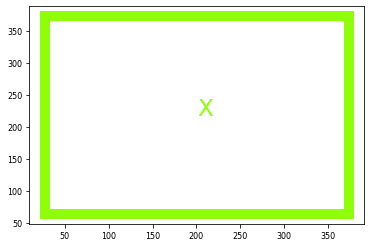

In [29]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = generator_config["GRID_"  + wh] ## 13
        IMAGE_      = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)

#plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()
                    

------------------------------
igrid_h=06,igrid_w=08,iAnchor=02, bus
igrid_h=08,igrid_w=02,iAnchor=01, person
igrid_h=08,igrid_w=05,iAnchor=00, person
igrid_h=09,igrid_w=03,iAnchor=01, person


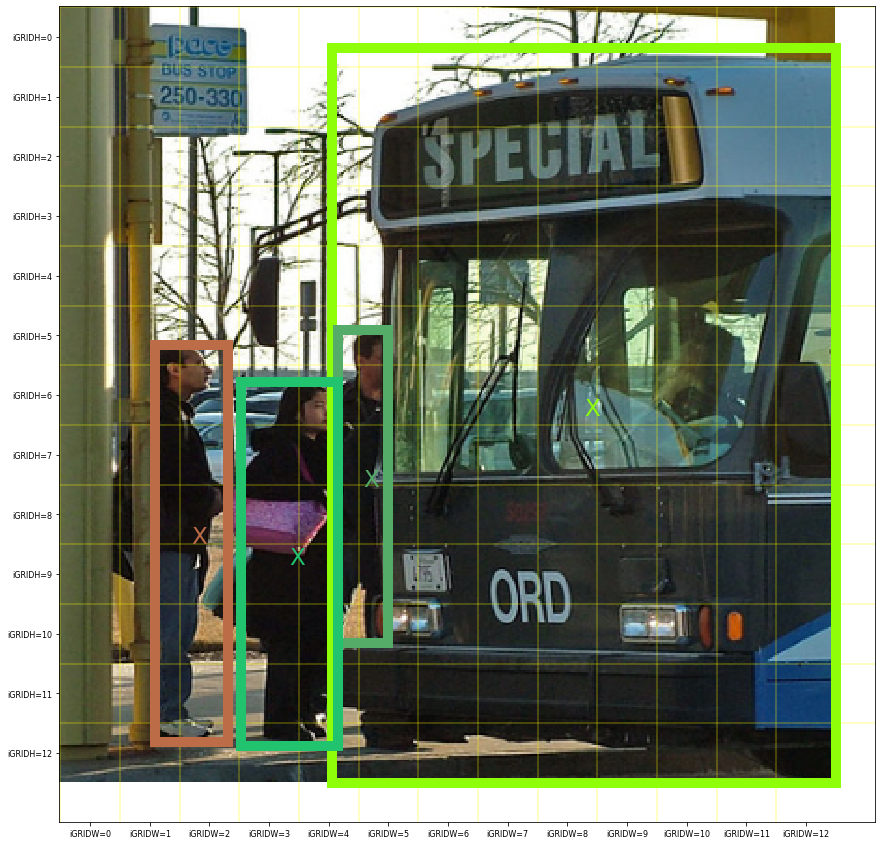

------------------------------
igrid_h=07,igrid_w=05,iAnchor=03, boat
igrid_h=09,igrid_w=08,iAnchor=00, person
igrid_h=09,igrid_w=09,iAnchor=00, person


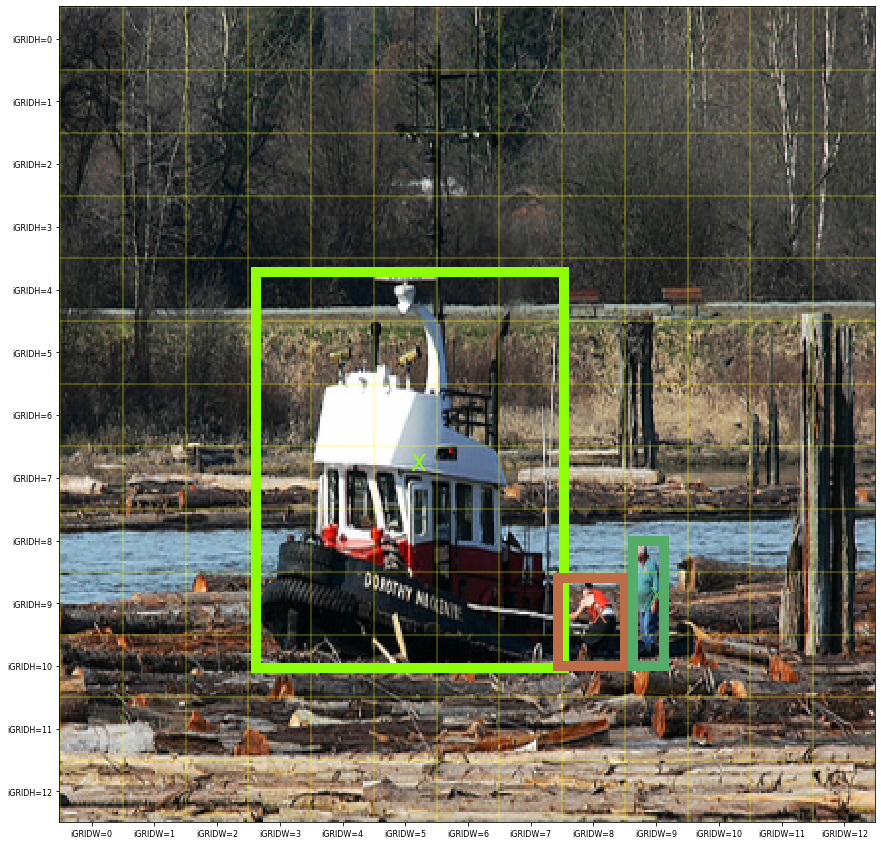

------------------------------
igrid_h=06,igrid_w=03,iAnchor=01, person
igrid_h=06,igrid_w=08,iAnchor=01, person


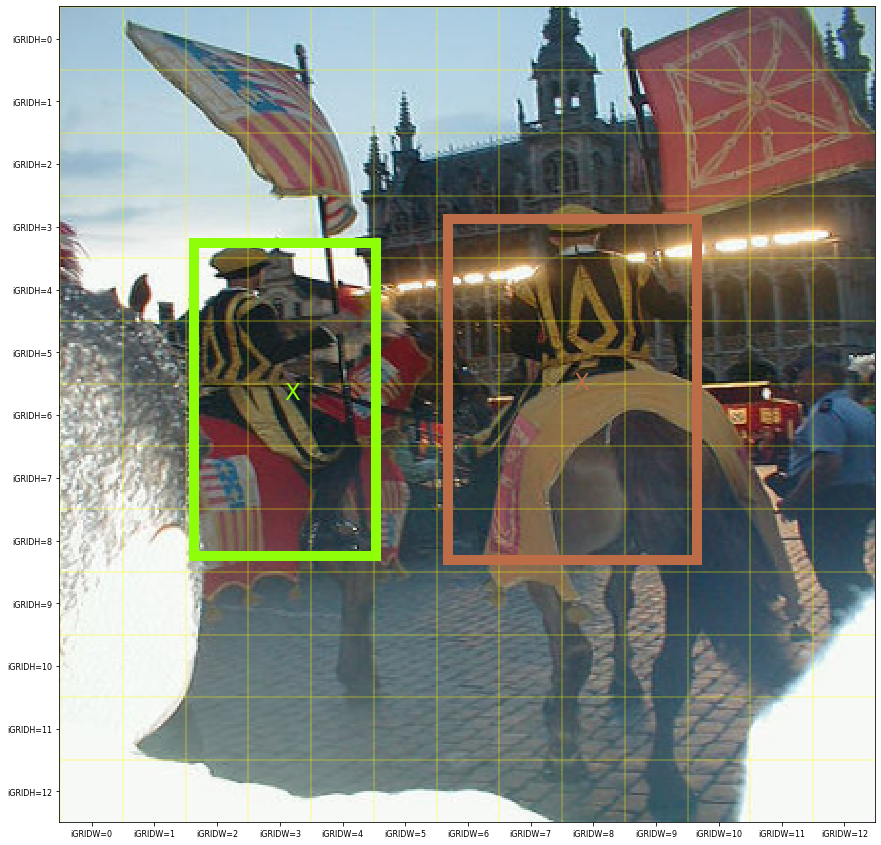

------------------------------
igrid_h=04,igrid_w=05,iAnchor=00, car
igrid_h=04,igrid_w=11,iAnchor=00, car
igrid_h=06,igrid_w=07,iAnchor=02, person
igrid_h=08,igrid_w=06,iAnchor=02, bicycle


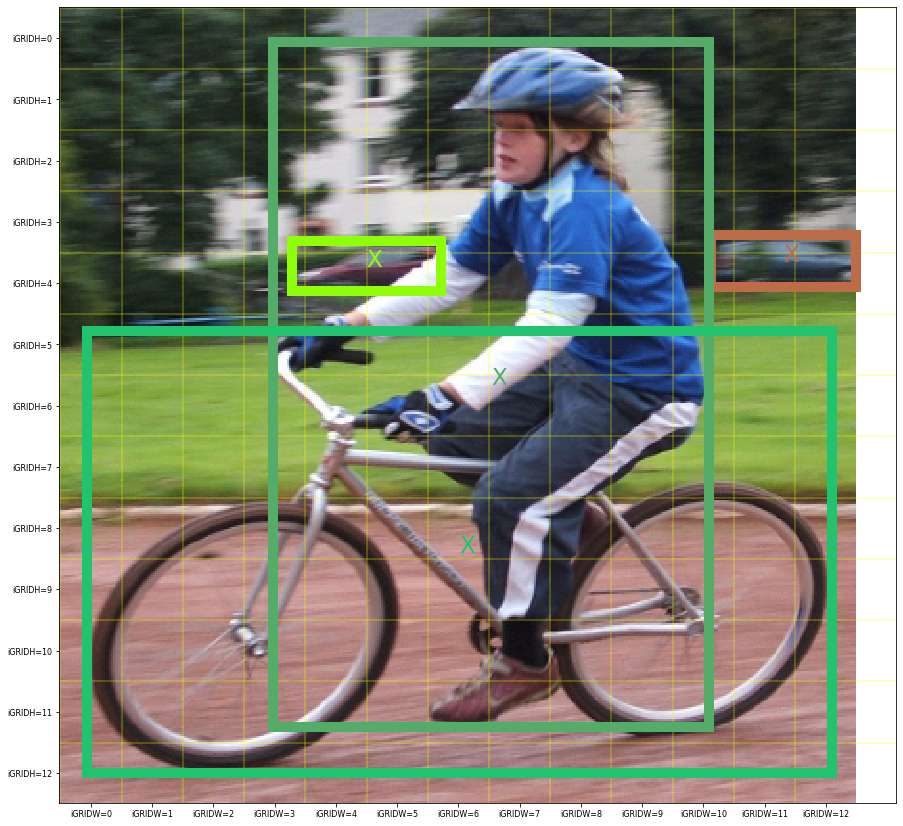

------------------------------
igrid_h=06,igrid_w=04,iAnchor=02, person
igrid_h=11,igrid_w=03,iAnchor=01, bottle


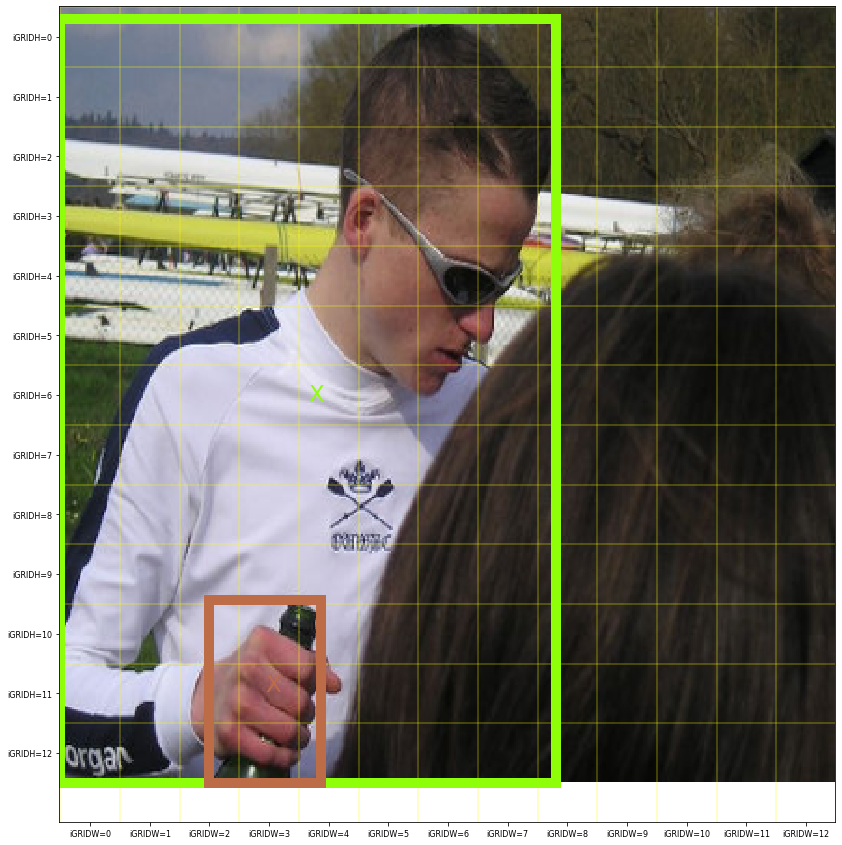

In [30]:
for irow in range(5,10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()
